In [123]:
# data format:  timestamp, src, dest, length, src port, dst port

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

print('done.')
#print('')
#print("Is CUDA available?", torch.cuda.is_available())

done.


In [124]:
# load data
print('Loading data...')
data = np.load('data_correct.npy')
nsamples = data.shape[0] 
max_src = data[:,1].max()
data = torch.tensor(data).float()
print("Samples:", nsamples,"\n") #prima 6.156.726

# prepare timestamps
print('Pre-processing timestamps...\n')
for i in range(int(max_src)):
    timestamps = data[ data[:,1] == i, 0 ] 
    timestamps[1:] = timestamps[1:] - timestamps[:-1] 
    timestamps[0] = 0 
    data[ data[:,1] == i, 0 ] = timestamps 

### shuffle the data
print('Shuffle the bit...\n')
data = data[ torch.randperm(data.shape[0]) ]
 
# split in training, validation and test set
print('Creating dataset...')
train = data[:int(nsamples*0.6)]
validation = data[int(nsamples*0.6):int(nsamples*0.8)]
test = data[int(nsamples*0.8):]


print("Samples train:", train.shape[0])
print("Samples validation:", validation.shape[0])
print("Samples test:", test.shape[0])
print("Total samples:", data.shape[0])

print('\ndone.')

Loading data...
Samples: 2054165 

Pre-processing timestamps...

Shuffle the bit...

Creating dataset...
Samples train: 1232499
Samples validation: 410833
Samples test: 410833
Total samples: 2054165

done.


In [125]:
# define network
class Net(nn.Module): 
    def __init__(self): 
        super(Net,self).__init__() 
        self.loss_fn = nn.CrossEntropyLoss()  # LogSoftmax + ClassNLL Loss 
        
        self.layers = nn.Sequential( 
            nn.Linear(5,30), #Input "mac source","Destination","source port","dest port"
            nn.ReLU(), 
            nn.Linear(30,90), 
            nn.ReLU(), 
            nn.Linear(90,90)            
            #nn.Softmax()   ### nn.CrossEntropyLoss() computes softmax by itself!
        )
        
    def forward(self,x): 
        return self.layers(x)
    
    def loss_function(self, net_out, target): 
        return self.loss_fn(net_out, target)
    
print('done.')

done.


In [126]:
# hyper-params
#stop_at = train.shape[0] - 1
stop_at = 10000 #speedsup a quick test by reducing the dataset
nbatch = 64
lear_rate = 1e-4
n = 10 #epoch
stamp = 1

In [127]:
# network preparation
print("Creating the model...\n")
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
net.to(device)
optimizer = optim.Adam(params=net.parameters(), lr=lear_rate)

Creating the model...



Start training...
2021-03-03 14:43:52.058028
Epoch 0, MeanLoss: 4732.143, Accuracy val: 0.717%
Epoch 1, MeanLoss: 862.073, Accuracy val: 0.657%
Epoch 2, MeanLoss: 211.567, Accuracy val: 1.214%
Epoch 3, MeanLoss: 92.948, Accuracy val: 1.204%
Epoch 4, MeanLoss: 55.297, Accuracy val: 2.428%
Epoch 5, MeanLoss: 49.377, Accuracy val: 1.523%
Epoch 6, MeanLoss: 44.356, Accuracy val: 5.484%
Epoch 7, MeanLoss: 44.348, Accuracy val: 5.354%
Epoch 8, MeanLoss: 40.137, Accuracy val: 5.096%
Epoch 9, MeanLoss: 40.725, Accuracy val: 0.965%

Trained for 10 epochs in:  0:29:25.299333

Best value of validation is: 5.484 % at 6 epoch



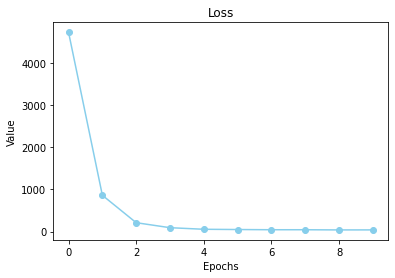

In [128]:
max_acc = 0
listLoss = []
listAccuracy_val = []

# train
print("Start training...")
print(datetime.now())

for epoch in range(n):  

    dateTimeObj_start= datetime.now()    
    net.train()
    mean_loss = 0.
    correct = 0    
    for it,batch in enumerate(train.split(nbatch)): 
        if it*nbatch > stop_at: break
        batch = batch.to(device) 
        targets = batch[:,1].long()   
        net_input = batch[:,(0,2,3,4,5)]  
        optimizer.zero_grad()     

        output = net(net_input)
        loss = net.loss_function(output, targets)  # that loss hides the one-hot encoding
        loss.backward() # Back propagation
        optimizer.step() # Updating gradients
        mean_loss += loss.item() #media delle loss delle predizioni

    dateTimeObj_end = datetime.now()

    net.eval() #evaluation, cambia lo stato del modello
    with torch.no_grad(): #non modificare la rete
        correct_eval = 0
        for it_eval,batch_eval in enumerate(validation.split(nbatch)):  
            if it_eval*nbatch > stop_at: break
            targets_eval = batch_eval[:,1].long()
            net_input_eval = batch_eval[:,(0,2,3,4,5)]
            optimizer.zero_grad()
            output_eval = net(net_input_eval)
            _, predicted_eval = torch.max(output_eval.data, 1)#?
            correct_eval += (predicted_eval == targets_eval).sum()

    tot = it_eval*nbatch
    accuracy_eval = 1.*correct_eval/tot

    
    listLoss.append(mean_loss/it)
    listAccuracy_val.append(accuracy_eval)


    if epoch%stamp == 0 or epoch == n-1: print(f"Epoch {epoch}, MeanLoss: {round((mean_loss/it), 3)}, Accuracy val: {round((100.*accuracy_eval.item()),3)}%")



dateTimeObj_end = datetime.now()
print()
print("Trained for " + str(n) + " epochs in: ", dateTimeObj_end-dateTimeObj_start_0)
print()

max_val = max(listAccuracy_val)
for i,element in enumerate(listAccuracy_val):
    if element == max_val:
        break
print("Best value of validation is:", round(element.item(),5)*100,"% at", i, "epoch")
print()
# Graphic
listLoss = np.asarray(listLoss, dtype=np.float32)
listAccuracy_val = np.asarray(listAccuracy_val, dtype=np.float32)

epochs = range(n)

df_train = pd.DataFrame({'Epochs': epochs, 'Loss': listLoss})
df_acc_val = pd.DataFrame({'Epochs': epochs, 'Accuracy': listAccuracy_val*100})
    
# plot
plt.plot( 'Epochs', 'Loss', data = df_train, linestyle='-', marker='o', color = 'skyblue' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.show()

In [130]:
# test
net.eval() #evaluation
with torch.no_grad(): #non modificare la rete
    correct = 0
    for it,batch in enumerate(test.split(64)): 
        #if it*64 > stop_at: break #riduce il carico, limita a 100k tuple
            
        batch = batch.to(device) 
        targets = batch[:,1].long()
        net_input = batch[:,(0,2,3,4,5)]
        
        output = net(net_input) 
        _, predicted = output.max(dim=1) 
        correct += (predicted == targets).sum() 

    score = (100. * correct / (it*64)).item()    
    print(f"Accuracy test: {round(score,3)} %")

Accuracy test: 0.873 %
